# I. Libraries importation

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import json,urllib.request
import os
import matplotlib.pyplot as plt
import pickle
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import geopandas as gpd

from urllib.request import urlopen
import plotly.express as px
import json

import folium
import numpy as np
from geopy.distance import geodesic

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'colab'
from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots

import json

import pycountry

from branca.colormap import LinearColormap

from datetime import date

from datetime import datetime
import seaborn as sns

from datetime import timedelta
import csv
import fitbit
import sys, os
from collections import deque
import cherrypy
import gather_keys_oauth2 as Oauth2
from plotly.subplots import make_subplots
import plotly.io as pio
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


# II. Data importation

In [2]:
#https://www.manishkurse.com/PythonProjects/Analyze_Fitbit_Data.html

In [3]:
#From your Fitbit account, you have to request an access to the API and get your credentials
CLIENT_ID='XXXXX'
CLIENT_SECRET='XXXXXX'

In [4]:
#To connect to the Fitbit API
server=Oauth2.OAuth2Server(CLIENT_ID, CLIENT_SECRET)
server.browser_authorize()
ACCESS_TOKEN=str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN=str(server.fitbit.client.session.token['refresh_token'])
auth_client=fitbit.Fitbit(CLIENT_ID,CLIENT_SECRET,oauth2=True,access_token=ACCESS_TOKEN,refresh_token=REFRESH_TOKEN)


[13/Aug/2021:16:03:58] ENGINE Listening for SIGTERM.
[13/Aug/2021:16:03:58] ENGINE Listening for SIGHUP.
[13/Aug/2021:16:03:58] ENGINE Listening for SIGUSR1.
[13/Aug/2021:16:03:58] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[13/Aug/2021:16:03:58] ENGINE Started monitor thread 'Autoreloader'.
[13/Aug/2021:16:03:58] ENGINE Serving on http://127.0.0.1:8080
[13/Aug/2021:16:03:58] ENGINE Bus STARTED


127.0.0.1 - - [13/Aug/2021:16:04:17] "GET /?code=ad8f1ca0b0f88adbd516d0a61d457b06bd53c2b6&state=I5bv1uaBcot13q38aCksO5uZPnma85 HTTP/1.1" 200 122 "" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.1 Safari/605.1.15"


[13/Aug/2021:16:04:18] ENGINE Bus STOPPING
[13/Aug/2021:16:04:18] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[13/Aug/2021:16:04:18] ENGINE Stopped thread 'Autoreloader'.
[13/Aug/2021:16:04:18] ENGINE Bus STOPPED
[13/Aug/2021:16:04:18] ENGINE Bus EXITING
[13/Aug/2021:16:04:18] ENGINE Bus EXITED
[13/Aug/2021:16:04:18] ENGINE Waiting for child threads to terminate...


In [48]:
# Function to get the latest Fitbit data from the API.

#Extract the activity data from the API, only the one that are missing from the existing database
def get_latest_fitbit_data(authd_client, last_log_date, yesterday):
    
    last_log_date_str = datetime.strftime(last_log_date,"%Y-%m-%d")
    yesterday_str = datetime.strftime(yesterday,"%Y-%m-%d")
    
    # Retrieve time series data by accessing Fitbit API. 
    # Note that the last logged date is the first date because data only upto yesterday gets written into csv.
    # Today is not over, hence incomplete data from today is not logged.

    steps = authd_client.time_series('activities/steps', base_date= last_log_date_str ,end_date=yesterday_str)
    cals = authd_client.time_series('activities/calories', base_date= last_log_date_str ,end_date=yesterday_str)
    dist = authd_client.time_series('activities/distance', base_date= last_log_date_str ,end_date=yesterday_str)
    floors = authd_client.time_series('activities/floors', base_date= last_log_date_str ,end_date=yesterday_str)
    sedant = authd_client.time_series('activities/minutesSedentary', base_date= last_log_date_str ,end_date=yesterday_str)
    elevation = authd_client.time_series('activities/elevation', base_date= last_log_date_str ,end_date=yesterday_str)
    active_light = authd_client.time_series('activities/minutesLightlyActive', base_date= last_log_date_str ,end_date=yesterday_str)
    active_fair = authd_client.time_series('activities/minutesFairlyActive', base_date= last_log_date_str ,end_date=yesterday_str)
    active_very = authd_client.time_series('activities/minutesVeryActive', base_date= last_log_date_str ,end_date=yesterday_str)

    df = pd.DataFrame()
    num_days = yesterday - last_log_date + timedelta(1)
    date_list = [last_log_date.date() + timedelta(days=x) for x in range(0, num_days.days)]
    df['date'] = date_list
    df['calories'] = pd.DataFrame(cals['activities-calories'])['value'].astype(int)
    df['steps'] = pd.DataFrame(steps['activities-steps'])['value'].astype(int)
    df['dist'] = pd.DataFrame(dist['activities-distance'])['value'].astype(float)
    df['floors'] = pd.DataFrame(floors['activities-floors'])['value'].astype(int)
    df['elevation'] = pd.DataFrame(elevation['activities-elevation'])['value'].astype(float)
    df['sedant'] = pd.DataFrame(sedant['activities-minutesSedentary'])['value'].astype(int)
    df['active_light'] = pd.DataFrame(active_light['activities-minutesLightlyActive'])['value'].astype(int)
    df['active_fair'] = pd.DataFrame(active_fair['activities-minutesFairlyActive'])['value'].astype(int)
    df['active_very'] = pd.DataFrame(active_very['activities-minutesVeryActive'])['value'].astype(int)
    
    return df

#Extract the exercise data from the API, only the one that are missing from the existing database
def get_latest_exercise_data(authd_client, last_log_date, yesterday):
    
    last_log_date_str = datetime.strftime(last_log_date,"%Y-%m-%d")
    yesterday_str = datetime.strftime(yesterday,"%Y-%m-%d")
    new_exercise=pd.DataFrame()
    
    try:
            i=last_log_date
            while i<yesterday:
                i_str = datetime.strftime(i,"%Y-%m-%d")
                activity_day = auth_client.activities(i_str)
                new_exercise=new_exercise.append(activity_day['activities'],ignore_index=True)
                print(i)
                i = i + timedelta(days=1)
    except:
            print("Too many request, last date took :"+str(i))
    return new_exercise

#Save the data in a csv file
def write_fitbit_data_to_csv(df,data_filename,log_filename,last_log_date):
    # Write the data frame to csv.
    with open(data_filename, 'a') as f:
        df.to_csv(f, header=False,index = False)

    # Log current date as the date last logged.
    today = datetime.today()
    today_str = datetime.strftime(today,"%Y-%m-%d")

    with open(log_filename,'a') as csvfile:
        csvwrite = csv.writer(csvfile, delimiter=',')
        csvwrite.writerow(['Data last logged',today_str])
        
        
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n) 

#Global function using the other function defined above to have the final result  
def obtain_write_new_data():

    # Create an oauth and oauth2 client 
    authd_client2 = fitbit.Fitbit(CLIENT_ID, CLIENT_SECRET, resource_owner_key =ACCESS_TOKEN, resource_owner_secret =REFRESH_TOKEN)
    authd_client = fitbit.Fitbit(CLIENT_ID, CLIENT_SECRET, oauth2=True, access_token=ACCESS_TOKEN, refresh_token=REFRESH_TOKEN)

    # Read log file to find out the last day Fitbit data was logged
    with open('Data/Data_log_dates.csv') as csvfile:
        temp = deque(csv.reader(csvfile), 1)[0]
    
    # Get yesterday's date and last logged date in both datetime format and in string format
    # Data from today is incomplete and not logged. So we are interested in yesterday's date.
    last_log_date = datetime.strptime(temp[1],"%Y-%m-%d")
    #today = datetime.today()-timedelta(days=1300)
    today=datetime.today()
    today_str = datetime.strftime(today,"%Y-%m-%d")
    yesterday = today - timedelta(days=1)

    # Get latest fitbit daily data
    df = get_latest_fitbit_data(authd_client,last_log_date,yesterday)
    exercise=get_latest_exercise_data(authd_client, last_log_date, yesterday)
    
    # Add latest daily data to daily data csv file
    last_log_date_str = datetime.strftime(last_log_date,"%Y-%m-%d")
    if last_log_date_str!=today_str:
        write_fitbit_data_to_csv(df,'Data/Daily_Fitbit_Data.csv','Data/Data_log_dates.csv',last_log_date_str)
        write_fitbit_data_to_csv(exercise,'Data/exercise.csv','Data/Data_log_dates.csv',last_log_date_str)
        
#    return(df)

In [ ]:
obtain_write_new_data()

In [ ]:
#Do not run, it was done one time, and save, now only has to be loaded
#Create a list with the GPS coordinates of each city

'''location=pd.read_excel('lieux.xlsx')

city = location[['Country','City']]
city=city.drop_duplicates(subset=['Country','City'])

list_lat = []   # create empty lists
list_long = []

for index, row in city.iterrows(): # iterate over rows in dataframe
    
    town = row['City']
    country = row['Country']
    query =str(town)+','+str(country)
    geolocator = Nominatim(user_agent="foursquare_agent")
    try:
        results = geolocator.geocode(query)
        try:
            lat = results.latitude
            long = results.longitude
        except:
            lat=0
            long=0
    except:
        lat=0
        long=0
    list_lat.append(lat)
    list_long.append(long)
    
city['lat'] = list_lat   
city['lon'] = list_long


with open('city.pickle', 'wb') as handle:
    pickle.dump(city, handle, protocol=pickle.HIGHEST_PROTOCOL)'''

In [6]:
#Extract the information of the location / place at day granularity
location=pd.read_excel('lieux.xlsx')
location['dateTime']= pd.to_datetime(location['Date'])
location=location.drop(columns=['Day of week ', 'Day ','Date'], axis=1)


In [7]:
#Get from the internet the country shapes information, to be able to display on a map
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json'

list_countries = location['Country'].unique().tolist()
d_country_code = {}  # To hold the country names and their ISO
for country in list_countries:
    try:
        country_data = pycountry.countries.search_fuzzy(country)
        # country_data is a list of objects of class pycountry.db.Country
        # The first item  ie at index 0 of list is best fit
        # object of class Country have an alpha_3 attribute
        country_code = country_data[0].alpha_3
        d_country_code.update({country: country_code})
    except:
        print('could not add ISO 3 code for ->', country)
        # If could not find country, make ISO code ' '
        d_country_code.update({country: ' '})

could not add ISO 3 code for -> nan


In [8]:
#Extract from the previously created table the data on GPS coordinates of each city
with open('city.pickle', 'rb') as handle:
    city = pickle.load(handle)
    
city=city.drop(columns=['Country'], axis=1)

In [9]:
#Extract from the csv file the activity data and create a dataframes with it 
data = pd.read_csv('Data/Daily_Fitbit_Data.csv')

In [10]:
#Extract from the csv file the exercise data and create a dataframes with it 
exercise = pd.read_csv('Data/exercise.csv', delimiter=',')


# III. Data pre-processing

## 1. Locations

In [11]:
#Add coordinates to city 
location_coord=location
location_coord=location.merge(city,on="City")


In [12]:
#Check coordinates of Paris to center the maps
geolocator = Nominatim(user_agent="foursquare_agent")
latitude=geolocator.geocode('Paris').latitude
longitude=geolocator.geocode('Paris').longitude

## 2. Activity data

In [13]:
#First data crunching
data=data.drop_duplicates()
data['dateTime']=pd.to_datetime(data['date'])

In [14]:
data

,date,calories,steps,dist,floor,elevation,sedant,active_light,active_fair,active_very,dateTime
0,2017-02-16,2591.24,7642,3.589875,16.0,160.0,751,211,10,25,2017-02-16
1,2017-02-17,3381.67,12396,5.823120,31.0,310.0,613,232,13,119,2017-02-17
2,2017-02-18,2316.68,5967,2.803031,9.0,90.0,706,153,27,28,2017-02-18
3,2017-02-19,2735.91,4513,2.119987,13.0,130.0,694,140,5,90,2017-02-19
4,2017-02-20,2330.76,4907,2.305063,16.0,160.0,738,168,8,18,2017-02-20
...,...,...,...,...,...,...,...,...,...,...,...
1629,2021-08-03,2560.00,11904,5.612368,16.0,160.0,666,270,13,34,2021-08-03
1630,2021-08-04,2757.00,17125,8.290167,31.0,310.0,684,241,27,69,2021-08-04
1631,2021-08-05,3337.00,13390,6.267255,32.0,320.0,479,356,53,84,2021-08-05
1632,2021-08-06,3316.00,27203,12.757322,31.0,310.0,847,247,146,71,2021-08-06


In [15]:
#Data pre process, to adjust the column name, some additional info on time parameters

data=data.rename(columns={"dist": "Distance", "steps": "Steps", "active_very": "Very active Minutes", "active_fair": "Moderately active Minutes", "sedant": "Sedentary Minutes", "floor": "Floor", "active_light": "Lightly active Minutes", "calories": "Calories"})
data['Distance']=data['Distance']*1.60934 #Translate miles in km
data['dayOfWeek'] = data['dateTime'].dt.day_name()
data['monthOfYear'] = data['dateTime'].dt.month_name()
data['Year'] = data["dateTime"].dt.strftime('%Y')
data['monthlayout'] = data["dateTime"].dt.strftime('%Y%m')
data = data[(data['monthlayout'] != "201702")]
data = data[(data['monthlayout'] != "202108")]
data = data[(data['Steps']>100)]
data
#Gather and merge the data together with the location
data_all= data.merge(location_coord,on="dateTime")
data_all['All_Minutes_active']=data_all['Very active Minutes']+data_all['Moderately active Minutes']+data_all['Lightly active Minutes']
data_all["Year"] = data_all["dateTime"].dt.strftime('%Y')
data_all["Steps_Vs_Target"] = (data_all["Steps"]-8000)


#Split the dataframes to have smaller one focusing on a single parameter
walk = pd.DataFrame(data, columns = ['dateTime', 'Distance','Steps','dayOfWeek','monthOfYear'])
floor = pd.DataFrame(data, columns = ['dateTime', 'Floor']) 
calories = pd.DataFrame(data, columns = ['dateTime', 'Calories']) 
minutes_all = pd.DataFrame(data, columns = ['dateTime', 'Very active Minutes', 'Moderately active Minutes', 'Lightly active Minutes', 'Sedentary Minutes','dayOfWeek','monthOfYear']) 

### a. Distances & Steps

In [16]:
#create walk with month x year granularity
walk_m=walk.groupby(pd.Grouper(key="dateTime",freq='M')).agg({'Distance': ['sum', 'mean','max','min'],'Steps': ['sum', 'mean','max','min']}).reset_index().rename(columns={'Distance':'Distance','dateTime':'date'})
walk_m['date'] = walk_m['date'].dt.strftime('%Y%m')
walk_m.columns = ["_".join(x) for x in walk_m.columns.ravel()]
walk_m=walk_m.rename(columns={"date_": "Month"})

#create walk with month granularity
walk_monthofyear=walk.groupby("monthOfYear").agg({'Distance': ['sum', 'mean','max','min'],'Steps': ['sum', 'mean','max','min']}).reset_index().rename(columns={'Distance':'Distance','monthOfYear':'monthOfYear'})
walk_monthofyear.columns = ["_".join(x) for x in walk_monthofyear.columns.ravel()]
walk_monthofyear=walk_monthofyear.rename(columns={"monthOfYear": "Month"})

#create walk with day of week granularity
walk_dayofweek=walk.groupby("dayOfWeek").agg({'Distance': ['sum', 'mean','max','min'],'Steps': ['sum', 'mean','max','min']}).reset_index().rename(columns={'Distance':'Distance','dayOfWeek':'dayOfWeek'})
walk_dayofweek.columns = ["_".join(x) for x in walk_dayofweek.columns.ravel()]
walk_dayofweek=walk_dayofweek.rename(columns={"dayOfWeek": "Day"})

#create walk with year granularity
walk_y=walk.groupby(pd.Grouper(key="dateTime",freq='Y')).agg({'Distance': 'sum','Steps': 'sum'}).reset_index().rename(columns={'Distance':'Distance','dateTime':'date'})
walk_y['date'] = walk_y['date'].dt.strftime('%Y')
walk_y['Distance']=walk_y['Distance']

#adding the city and country info
walk_d= walk.merge(location_coord,on="dateTime")

#Aggregate by city
walk_d_city=walk_d.groupby("City").agg({'Distance': 'sum','Steps': 'sum','lat': 'mean','lon': 'mean'}).reset_index()

#Aggregate by country
walk_d_country=walk_d.groupby("Country").agg({'Distance': 'sum','Steps': 'sum','lat': 'mean','lon': 'mean'}).reset_index()

#Aggregate by country and by year
walk_d_country_year=walk_d.groupby(["Country",pd.Grouper(key="dateTime",freq='Y')]).agg({'Distance': 'sum','Steps': 'sum'}).reset_index()
walk_d_country_year["Year"] = walk_d_country_year["dateTime"].dt.strftime('%Y')
walk_d_country_year=walk_d_country_year.drop(columns=["dateTime"], axis=1)
walk_d_country_year=walk_d_country_year.sort_values("Year")

#walk_day0week=walk.groupby(by="dayOfWeek").agg({'Distance': ['sum', 'mean','max','min'],'Steps': ['sum', 'mean','max','min']}).reset_index().rename(columns={'Distance':'Distance','dateTime':'date'})

In [17]:
walk_m.head(15)

,Month,Distance_sum,Distance_mean,Distance_max,Distance_min,Steps_sum,Steps_mean,Steps_max,Steps_min
0,201703,290.04155,9.356179,19.13283,4.28424,382569,12340.935484,25308,5667
1,201704,281.67585,9.389195,17.01903,0.64789,342924,11430.800000,22512,857
2,201705,269.01016,8.677747,16.70599,2.51376,340495,10983.709677,22098,3325
3,201706,355.81268,11.860423,19.71958,4.86715,443341,14778.033333,26084,6438
4,201707,351.50350,11.338823,21.40157,4.77034,438292,14138.451613,28309,6310
5,201708,340.51940,10.984497,24.48038,4.87389,424943,13707.838710,30862,6447
6,201709,320.08706,10.669569,19.49386,5.20144,400646,13354.866667,24648,6844
7,201710,310.30092,10.009707,24.66685,2.64784,393324,12687.870968,32018,3484
8,201711,350.28653,11.676218,29.76954,3.76124,451667,15055.566667,39123,4949
9,201712,258.28751,8.331855,13.84036,3.89500,316960,10224.516129,18211,4807


### b. Minutes active

In [18]:
#create a unique dataframe with all minutes
minutes_all=minutes_all.sort_values('dateTime')

#adding the city and country info
minutes_all= minutes_all.merge(location_coord,on="dateTime")
minutes_all=minutes_all.sort_values('dateTime')

### c. Floor

In [19]:
#create altitude with month granularity

floor_d=floor.groupby(pd.Grouper(key="dateTime",freq='D')).agg({'Floor': 'sum'}).reset_index()
floor_d['Floor'] = floor_d['Floor']/10

### d. Calories

In [20]:
#create calories with month granularity

calories_d=calories.groupby(pd.Grouper(key="dateTime",freq='D')).agg({'Calories': 'sum'}).reset_index()


## 3. Exercises data

In [21]:
#First data crunching

exercise_data=exercise.drop_duplicates(subset=['logId'])
exercise_data['date']=pd.to_datetime(exercise_data['startDate'])
exercise_data['duration_hour']=exercise_data['duration']/60000/60
exercise_data=exercise_data.drop_duplicates()
exercise_data['dayOfWeek'] = exercise_data['date'].dt.day_name()
exercise_data['monthOfYear'] = exercise_data['date'].dt.month_name()
exercise_data['datelayout'] = exercise_data['date'].dt.strftime('%Y%m')
exercise_data = exercise_data[(exercise_data['datelayout'] != "201702")]
exercise_data = exercise_data[(exercise_data['datelayout'] != "202108")]
exercise_data['COVID']=np.where(exercise_data['date']>='2020-03-17', 'Post Covid', 'Pre Covid')
exercise_data=exercise_data[(exercise_data['duration_hour'] < 3)]
exercise_data=exercise_data[(exercise_data['name'] !="Skiing")]

<ipython-input-21-b5f3cf4acebe>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-21-b5f3cf4acebe>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
#create exercice with month granularity

exercise_m=exercise_data.groupby(pd.Grouper(key="date",freq='M')).agg({'logId':'count', 'duration_hour': 'sum'}).reset_index().rename(columns={'logId':'number_of_trainings'})
exercise_m['date'] = exercise_m['date'].dt.strftime('%Y%m')
exercise_m['COVID']=np.where(exercise_m['date']>='202003', 'Lockdown', 'Pre Covid')
exercise_m = exercise_m[(exercise_m['date'] != "201702")]
exercise_m = exercise_m[(exercise_m['date'] != "202108")]

#create walk with year granularity
exercise_y=exercise_data.groupby(pd.Grouper(key="date",freq='Y')).agg({'logId':'count', 'duration_hour': 'sum'}).reset_index().rename(columns={'logId':'number_of_trainings'})
exercise_y['date'] = exercise_y['date'].dt.strftime('%Y')


# IV. Analysis

## 1. Overview

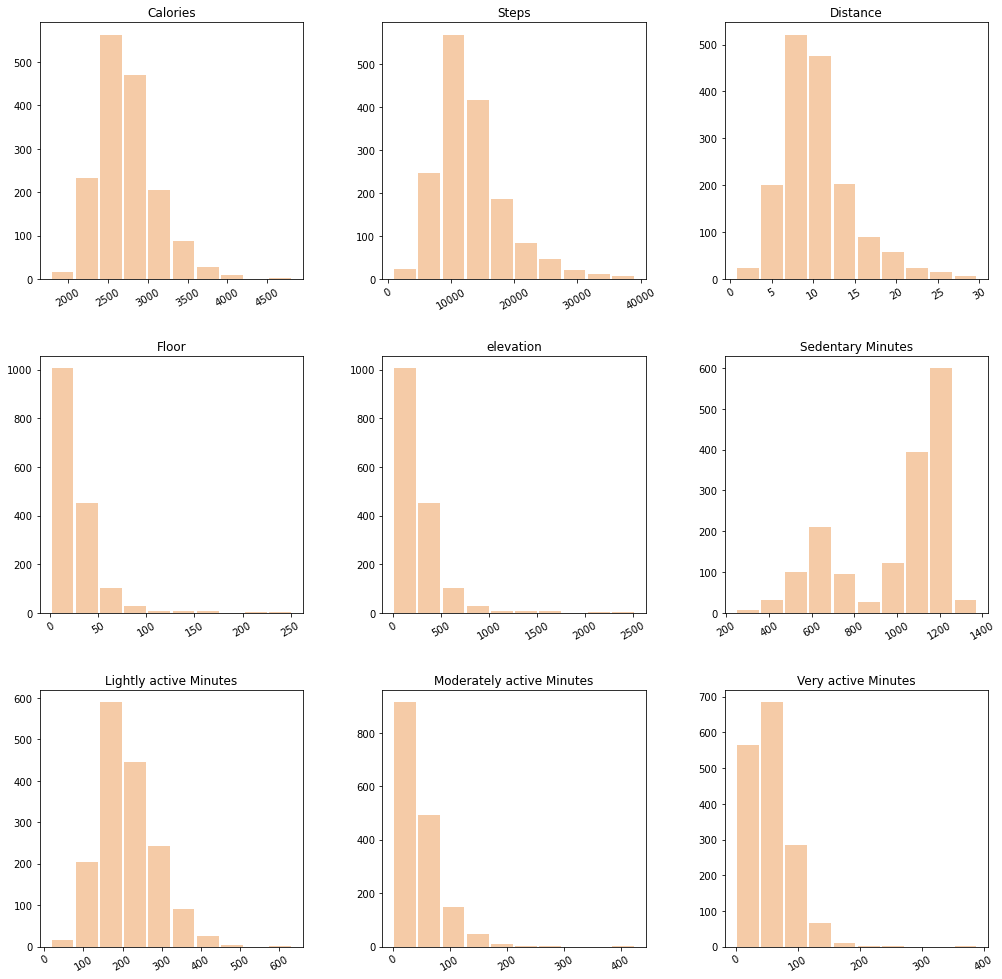

In [23]:
#create a global overview of the distribultion of the different parameters
histogram=data_all.drop(columns=["lat","lon","Steps_Vs_Target","All_Minutes_active"], axis=1)
h = histogram.hist(
    figsize = (17,17), 
    layout = (3,3),
    xrot = 30,
    grid=False,
    color='#F5CBA7', 
    zorder=2, 
    rwidth=0.9
)

## 1. Distance & Steps

In [24]:
#Daily average of the distance I walked in the last 4 years in km
walk_d["Distance"].mean()

10.39536402854486

In [25]:
#Distance I walked in total over the last 4 years in km
walk_d["Distance"].sum()

16798.90827012848

In [26]:
#Display in a combo graph the monthly steps and distance I walked in the last 4 years

trace1  = go.Scatter(
        mode='lines+markers',
        x = walk_m['Month'],
        y = walk_m['Steps_sum'],
        name="Steps",
        marker_color='purple'
    )

trace2 = go.Bar(
        x = walk_m['Month'],
        y = walk_m['Distance_sum'],
        name="Distance",
        yaxis='y2',
        marker_color ='rgb(240, 178, 122 )',
        marker_line_width=1.5,
        marker_line_color='rgb(240, 178, 122 )',
        opacity=0.5
    )

data = [trace1,trace2]


layout = go.Layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    title=dict(
        text='Walking Data: Distance and steps',
        xanchor='center',
        y=0.9,
        x=0.5,
        yanchor='top',
    ),
    yaxis=dict(
        title='Number of steps',
        side = 'right',
        rangemode = 'tozero',
        anchor='x',
    ),
    yaxis2=dict(
        overlaying='y',
        title='Distance (km)',
        anchor='y',
        rangemode = 'tozero',
        showgrid=False
    ),
    width=1400, 
    height=700,
    template="simple_white",
    uniformtext_minsize=12, 
    uniformtext_mode='hide',
    font=dict(
        family="Georgia, serif",
        size=18,
        color='rgb(23, 32, 42  )'
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [30]:
#The distance is a multiple of the number of step, I fill focus in the graph only on the distance. It displays the monthly distance I walked in the last 4 years

walk_m=walk_m.sort_values('Month')

fig = px.bar(
    walk_m, 
    y='Distance_sum', 
    x='Month', 
    orientation='v',
    template="simple_white",
    labels={'Month':'Month','Distance_sum':'Distance (km)'},
    width=1400, 
    height=700,
    text=round(walk_m["Distance_sum"]
              )
)


fig.update_layout(
    title='Distance per month',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Distance (km)',
        titlefont_size=16,
        tickfont_size=14
    ),
    legend=dict(
        x=1,
        y=1.0,
        bgcolor='rgb(36, 113, 163)',
        bordercolor='rgb(36, 113, 163)'
    ),
    margin=dict(l=40, r=40, t=40, b=40),
    bargap=0.10, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)

fig.update_traces(
    marker_color='rgb(169, 204, 227)', 
    marker_line_color='rgb(36, 113, 163)',
    marker_line_width=1.5, 
    opacity=0.8,
    texttemplate='%{text:.2s}', 
    textposition='inside',
    textfont=dict(
        family="sans serif",
        size=18,
        color='rgb(36, 113, 163)'
    )
)

fig.update_layout(
    title_x=0.5,
    uniformtext_minsize=12, 
    uniformtext_mode='hide',
    font=dict(
        family="Georgia, serif",
        size=18,
        color='rgb(23, 32, 42)'
    )
)
fig.show()

In [31]:
#Display in a graph the daily average distance I walk, by day of the week (regardless of the month and year)

fig = px.bar(
    walk_dayofweek,
    x="dayOfWeek_", 
    y="Distance_mean",
    text='Distance_mean',
    labels={'dayOfWeek_':'Days','Distance_mean':'Distance (km)'},
    title="Average distance per day",
    template="simple_white",
    width=1400, 
    height=700,
    category_orders={"dayOfWeek_": ["Monday", "Tuesday", "Wednesday", "Thursday","Friday", "Saturday","Sunday"]}
)

fig.update_traces(
    marker_color='rgb(215, 189, 226)',
    marker_line_color='rgb(99, 57, 116)',
    marker_line_width=1.5, 
    opacity=0.8,
    texttemplate='%{text:.2s}', 
    textposition='outside',
    textfont=dict(
        family="sans serif",
        size=18,
        color='rgb(99, 57, 116)'
    )
)

fig.update_layout(
    title_x=0.5,
    uniformtext_minsize=12, 
    uniformtext_mode='hide',
    font=dict(
        family="Georgia, serif",
        size=18,
        color='rgb(23, 32, 42)'
    )
)

fig.show()

In [32]:
#Give a little bit more insight on statistical parameter of the daily distance I walk, by day of the week (regardless of the month and year)

fig = px.box(
    walk, 
    x="dayOfWeek", 
    y="Distance",
    labels={'dayOfWeek':'Days','Distance':'Distance (km)'},
    title="Daily Distance",
    width=1400, 
    height=700,
    template="simple_white",
    category_orders={"dayOfWeek": ["Monday", "Tuesday", "Wednesday", "Thursday","Friday", "Saturday","Sunday"]}
)
fig.update_traces(
    marker_color='rgb(155, 89, 182)',
    marker_line_color='rgb(155, 89, 182)',
    line_color='rgb(155, 89, 182)',
    marker_line_width=1,
    opacity=0.8
)
fig.update_layout(
    title_x=0.5,
    font=dict(
        family="Georgia, serif",
        size=18,
        color='rgb(23, 32, 42 )'
    )
)
fig.show()

In [33]:
#Display in a graph the monthly average distance I walk, by month of the year  (regardless of the year)

fig = px.bar(
    walk_monthofyear,
    x="monthOfYear_",
    y="Distance_mean",
    text='Distance_mean',
    width=1400, 
    height=700,
    title="Average distance per month",
    template="simple_white",
    labels={'monthOfYear_':'Months','Distance_mean':'Distance (km)'},
    category_orders={"monthOfYear_": ["January", "February", "March", "April","May", "June","July","August","September","October","November","December"]}
)

fig.update_traces(
    marker_color='rgb(245, 203, 167 )',
    marker_line_color='rgb(147, 81, 22)',
    marker_line_width=1.5,
    opacity=0.6,
    texttemplate='%{text:.2s}', 
    textposition='outside',
    textfont=dict(
        family="sans serif",
        size=18,
        color='rgb(147, 81, 22 )'
    )
)

fig.update_layout(
    title_x=0.5,
    font=dict(
        family="Georgia, serif",
        size=18,
        color='rgb(23, 32, 42 )'
    )
)
fig.show()


In [34]:
#Give a little bit more insight on statistical parameter of the monthly distance I walk, by month of the year (regardless of the year)

fig = px.box(
    walk, 
    x="monthOfYear", 
    y="Steps",
    labels={'monthOfYear':'Months','Distance':'Distance (in km)'},
    title="Monthly Distance",
    width=1400, 
    height=700,
    template="simple_white",
    category_orders={"monthOfYear": ["January", "February", "March", "April","May", "June","July","August","September","October","November","December"]}
)
fig.update_traces(
    marker_color='rgb(240, 178, 122)', 
    marker_line_color='rgb(240, 178, 122)',
    line_color='rgb(240, 178, 122)',
    marker_line_width=1,
    opacity=0.8
)
fig.update_layout(
    title_x=0.5,
    font=dict(
        family="Georgia, serif",
        size=18,
        color='rgb(23, 32, 42 )'
    )
)
fig.show()

In [36]:
#Display in a graph the distribution of the daily distance I walked

df = px.data.tips()
fig = px.histogram(
    data_all, 
    x="Distance",
    labels={'Distance':'Distances (km)'},
    title="Distance distribution",
    width=1400, 
    height=700,
    template="simple_white",
)

fig.update_traces(
    marker_color='rgb(240, 178, 122)',
    marker_line_color='rgb(240, 178, 122)',
    marker_line_width=1.5,
    opacity=0.75,
)

fig.update_layout(
    title_x=0.5,
    font=dict(
        family="Georgia, serif",
        size=18,
        color='rgb(23, 32, 42 )'
    )
)
fig.show()

In [37]:
#Summerize the top 10 days when I walked the most, together with the city where I was at that time



top10=walk_d.sort_values('Distance',ascending=False)
top10=top10.head(15)
top10=top10.drop(columns=["Country"], axis=1)
top10["dateTime"] = top10["dateTime"].dt.round('d')
top10['dateTime'] = top10['dateTime'].dt.strftime('%B %d, %Y')

fig = px.bar(
    top10, 
    y='dateTime', 
    x='Distance',
    labels={'dateTime':'Date','Distance':'Distance (in km)'}, 
    orientation='h',
    text=top10["City"],
    title="Top 10",
    width=1400, 
    height=800,
    template="simple_white"
)

fig.update_yaxes(categoryorder='total ascending')

fig.update_traces(
    marker_color='rgb(169, 204, 227)',
    marker_line_color='rgb(36, 113, 163)',
    marker_line_width=1.5, 
    opacity=0.8, 
    textposition='inside',
    textfont=dict(
        family="sans serif",
        size=18,
        color='rgb(36, 113, 163)'
    )
)
fig.update_layout(
    title_x=0.5,
    font=dict(
        family="Georgia, serif",
        size=18,
        color='rgb(23, 32, 42)'
    )
)
fig.show()


In [38]:
# create map of Paris using latitude and longitude values
# Display for each city I was in in the last 4 years a circle logarithmic proportional to the distance I walked there



map_city = folium.Map(location=[latitude, longitude], zoom_start=2)

# add markers to map
for lat, lng, label,distance in zip(walk_d_city['lat'], walk_d_city['lon'], walk_d_city['City'],walk_d_city['Distance']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=np.log10(distance)*5,
        popup=label,
        color='#0E07BC',
        fill=True,
        fill_color='#0E07BC',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city)  
    
map_city

In [39]:
# Display on a map a country color scale depending on the distance I walked there in the last 4 years

map_country = folium.Map(location=[latitude, longitude], zoom_start=2)

myscale = (walk_d_country["Distance"].quantile((0,0.05,0.1,0.5,0.6,0.75,0.9,0.98,1))).tolist()

folium.Choropleth(
    geo_data=country_shapes,
    data=walk_d_country,
    fill_color='YlOrRd',
    threshold_scale=myscale,
    columns=['Country', 'Distance'],
    key_on='feature.properties.name', 
    fill_opacity=0.6, 
    line_opacity=0.2,
    legend_name='Distances by countries',
    nan_fill_color="purple",
    nan_fill_opacity=0,
    z=walk_d_country["Distance"],
    #reset=True
).add_to(map_country)


map_country

## 2. Exercises

In [ ]:
# Display in a combo graph the number of workout togerther with the duration of workout I did per month

trace1  = go.Scatter(
        mode='lines+markers',
        x = exercise_m['date'],
        y = exercise_m['duration_hour'],
        name="Duration (hours)",
        marker_color='rgb(33, 97, 140)'
    )

trace2 = go.Bar(
        x = exercise_m['date'],
        y = exercise_m['number_of_trainings'],
        name="Number of trainings",
        yaxis='y2',
        marker_color ='rgb(133, 193, 233 )',
        marker_line_width=1,
        marker_line_color='rgb(46, 134, 193)',
        opacity=0.5
    )

data = [trace1,trace2]

layout = go.Layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    title=dict(
        text='Workouts Data',
        xanchor='center',
        y=0.9,
        x=0.5,
        yanchor='top',
    ),
    yaxis=dict(
        title='Duration in hours',
        side = 'right',
        rangemode = 'tozero',
        anchor='x',
    ),
    yaxis2=dict(
        overlaying='y',
        title='Number of trainings',
        anchor='y',
        rangemode = 'tozero',
        showgrid=False
    ),
    width=1400, 
    height=700,
    template="simple_white",
    uniformtext_minsize=12, 
    uniformtext_mode='hide',
    font=dict(
        family="Georgia, serif",
        size=18,
        color='rgb(23, 32, 42  )'
    )
)
fig = go.Figure(data=data, layout=layout)


fig.show()



In [41]:
# Display in box plot information on workouts done depending on the sanitary situation



fig = px.box(
    exercise_m, 
    x="COVID", 
    y="duration_hour",
    labels={'COVID':'COVID','duration_hour':'Duration'},
    title="Duration of workouts per month",
    width=1400, 
    height=700,
    template="simple_white",
)
fig.update_traces(
    marker_color='rgb(33, 97, 140)', 
    marker_line_color='rgb(33, 97, 140)',
    line_color='rgb(33, 97, 140)',
    marker_line_width=1,
    opacity=0.8
)
fig.update_layout(
    title_x=0.5,
    font=dict(
        family="Georgia, serif",
        size=18,
        color='rgb(23, 32, 42)'
    )
)
fig.show()

In [42]:
# Display in box plot information on workouts done depending on the sanitary situation

fig = px.box(
    exercise_m, 
    x="COVID", 
    y="number_of_trainings",
    labels={'COVID':'COVID','number_of_trainings':'Number of workouts'},
    title="Number of workouts per month",
    width=1400, 
    height=700,
    template="simple_white",
)
fig.update_traces(
    marker_color='rgb(46, 134, 193)', 
    marker_line_color='rgb(46, 134, 193)',
    line_color='rgb(46, 134, 193)',
    marker_line_width=1,
    opacity=0.8
)
fig.update_layout(
    title_x=0.5,
    font=dict(
        family="Georgia, serif",
        size=18,
        color='rgb(23, 32, 42 )'
    )
)
fig.show()